In [1]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = "../../fig3/svg/panel_a.svg"
PANEL_B = "../svg/panel_b_016_fig1.svg"
PANEL_C = "../svg/panel_c_016_fig1.svg"
PANEL_D = "../svg/panel_d_016_fig1.svg"
PANEL_E1 = "../svg/panel_e1_016_fig1.svg"
PANEL_E2 = "../svg/panel_e2_016_fig1.svg"
PANEL_F1 = "../svg/panel_f1_016_fig1.svg"
PANEL_F2 = "../../fig3/svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1_016_fig1.svg"
PANEL_G2 = "../svg/panel_g2_016_fig1.svg"
PANEL_H1 = "../svg/panel_h1_016_fig1.svg"
PANEL_H2 = "../svg/panel_h2_016_fig1.svg"
PANEL_I1 = "../svg/panel_i1_016_fig1.svg"
PANEL_I2 = "../svg/panel_i2_016_fig1.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1_016_fig1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2_016_fig1.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3_016_fig1.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1_016_fig1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2_016_fig1.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3_016_fig1.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1_016_fig1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2_016_fig1.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3_016_fig1.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_min_burst_condition_circuit_parameters_016.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_min_burst_condition_simulation_outputs_016.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_min_burst_condition_seeds_016.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Simulate 10 samples and keep track of the energy consumption of each trace

In [7]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [8]:
torch.manual_seed(0)
params_with_seeds = np.concatenate(
    (
        theta_np[:20],
        seeds[:20][
            None,
        ].T,
    ),
    axis=1,
)
simulation_outputs = list(map(simulator, params_with_seeds))

In [9]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [10]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)

### Sketch of active subspace

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


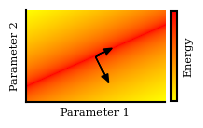

In [11]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.active_subspace_sketch()
    plt.savefig(PANEL_B, facecolor='None', transparent=False)

###  Fit regression net for total energy

In [12]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [14]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'
    posterior._sample_with = "rejection"

In [15]:
xo = np.load("../../../results/experimental_data/xo_11deg_016.npy")

In [16]:
energies = x["energies"]

In [17]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [18]:
num_test = 300

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [19]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [20]:
torch.manual_seed(0)
sensitivity = ActiveSubspace(posterior.set_default_x(xo))
converged_nn = sensitivity.add_property(
    theta_train, train_energy, hidden_features=20, num_blocks=1
).train()
e_vals, e_vecs = sensitivity.find_directions()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
predictions = converged_nn(theta_test).detach()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


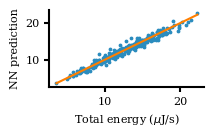

In [22]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy[:300]
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y.numpy()/10/1000, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()/10/1000), np.max(unnorm_x.numpy()/10/1000), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("NN prediction")
    plt.savefig(PANEL_supp_performance1, facecolor='None', transparent=False)

In [23]:
unnorm_y = predictions[:300]
mse = torch.mean(torch.abs(unnorm_x/10/1000 - unnorm_y/10/1000) ** 2)
print("mean squared error: ", mse)

mean squared error:  tensor(0.4597)


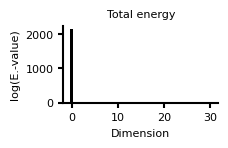

In [24]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.abs(torch.flip(e_vals, dims=(0,))),
        figsize=(2.0, 1.0),
        ylabel="log(E.-value)",
        color="k",
        title="Total energy"
    )
    plt.savefig(PANEL_supp_EV1, facecolor="None", transparent=False)
    plt.show()

In [25]:
print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

Ratio of first two eigenvalues:   tensor(67.4914)


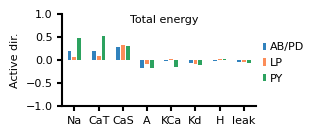

In [26]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 1.2),
        ylabel="Active dir.",
        plot_labels=True,
        title='Total energy',
    )
    plt.savefig(PANEL_C, facecolor="None", transparent=False)
    plt.show()

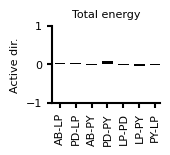

In [27]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(e_vecs[24:, -1:].T), ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel="Active dir.", color="k", title='Total energy'
    )
    plt.savefig(PANEL_supp_synapses1, facecolor="None", transparent=False)
    plt.show()

## Which parameters affect energy, which parameters influence energy?

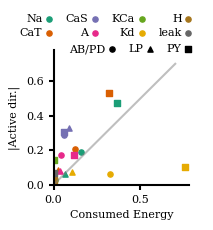

In [28]:
eigenvector = e_vecs[:, -1].numpy()

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.scatter_sensitivity_consumption(all_fractions, eigenvector, arrows=False)
    plt.savefig(PANEL_D, facecolor="None", transparent=False)

# Energy per spike

In [29]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["PM"].to_numpy()
all_energies_per_spike_ABPD_test = torch.as_tensor(
    all_energies_per_spike_ABPD[:num_test], dtype=torch.float32
).unsqueeze(1)
all_energies_per_spike_ABPD_train = torch.as_tensor(
    all_energies_per_spike_ABPD[num_test:], dtype=torch.float32
).unsqueeze(1)

In [30]:
torch.manual_seed(0)

sensitivity_e_per_spike = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_e_per_spike = sensitivity_e_per_spike.add_property(
    theta_train, all_energies_per_spike_ABPD_train, hidden_features=20, num_blocks=1
).train()
predictions = converged_nn_e_per_spike(theta_test).detach().numpy()
e_vals_e_per_spike, e_vecs_e_per_spike = sensitivity_e_per_spike.find_directions()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

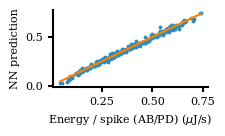

In [31]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = all_energies_per_spike_ABPD_test[:300].numpy()/1000
    unnorm_y = predictions[:300]/1000
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike (AB/PD) ($\mu$J/s)")
    ax.set_ylabel("NN prediction")
    plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(13.1238)


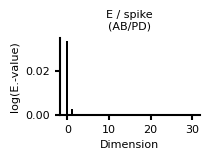

In [32]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.flip(torch.abs(e_vals_e_per_spike), dims=(0,)),
        figsize=(1.8, 1.0),
        ylabel="log(E.-value)",
        color="k",
        title="E / spike\n(AB/PD)"
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.savefig(PANEL_supp_EV2, facecolor="None", transparent=False)
    plt.show()

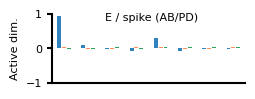

In [33]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        deepcopy(e_vecs_e_per_spike[:, -1].T),
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dim.",
        plot_labels=False,
        legend=False,
        title='E / spike (AB/PD)',
        title_x_offset=-0.6,
    )
    plt.savefig(PANEL_E1, facecolor="None", transparent=True)
    plt.show()

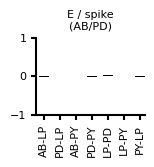

In [34]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_e_per_spike[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel="", color="k", title="E / spike\n(AB/PD)"
    )
    plt.savefig(PANEL_supp_synapses2, facecolor="None", transparent=False)
    plt.show()

## Number of spikes

In [35]:
numSpikesPerBurst = x["num_spikes"]["PM"].to_numpy() / x["num_bursts"]["PM"].to_numpy()
numSpikesPerBurst_test = torch.as_tensor(
    numSpikesPerBurst[:num_test], dtype=torch.float32
).unsqueeze(1)
numSpikesPerBurst_train = torch.as_tensor(
    numSpikesPerBurst[num_test:], dtype=torch.float32
).unsqueeze(1)

In [36]:
torch.manual_seed(0)

sensitivity_num_spikes = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_num_spikes = sensitivity_num_spikes.add_property(
    theta_train,
    numSpikesPerBurst_train,
    hidden_features=20,
    num_blocks=1
).train()
e_vals_num_spikes, e_vecs_num_spikes = sensitivity_num_spikes.find_directions()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
predictions = converged_nn_num_spikes(theta_test).detach().numpy()

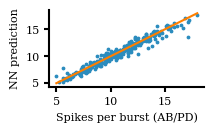

In [38]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = numSpikesPerBurst_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst (AB/PD)")
    ax.set_ylabel("NN prediction")
    plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(27.4754)


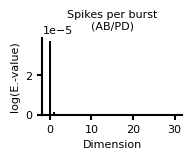

In [39]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.flip(torch.abs(e_vals_num_spikes), dims=(0,)),
        figsize=(1.8, 1.0),
        ylabel="log(E.-value)",
        color="k",
        title="Spikes per burst\n(AB/PD)"
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_num_spikes[-1] / e_vals_num_spikes[-2],
    )
    plt.savefig(PANEL_supp_EV3, facecolor="None", transparent=False)
    plt.show()

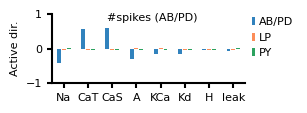

In [40]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs_num_spikes[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dir.",
        plot_labels=True,
        legend=True,
        legend_y_offset=0.3,
        title='#spikes (AB/PD)',
        title_x_offset=-0.5,
    )
    plt.savefig(PANEL_E2, facecolor="None", transparent=True)
    plt.show()

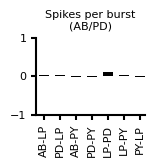

In [41]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_num_spikes[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel="", color="k", title="Spikes per burst\n(AB/PD)"
    )
    plt.savefig(PANEL_supp_synapses3, facecolor="None", transparent=False)
    plt.show()

# Relationship between the two

In [42]:
projected_e_per_spike = sensitivity_e_per_spike.project(theta_train, num_dimensions=1)
projected_num_spikes = sensitivity_num_spikes.project(theta_train, num_dimensions=1)

In [43]:
ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike, 0)
# ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike, 27)

ind_of_min_numSpikes = nth_argmin(projected_num_spikes, 0)
# ind_of_max_numSpikes = nth_argmax(projected_num_spikes, 0)

In [44]:
cond1 = projected_e_per_spike > -1.0
cond2 = projected_e_per_spike < -0.8
cond3 = projected_num_spikes > -0.7
cond4 = projected_num_spikes < -0.6

In [45]:
full_cond = torch.logical_and(
    torch.logical_and(torch.logical_and(cond1, cond2), cond3), cond4
)

In [46]:
fulfiling_param_sets = theta_train[full_cond[:, 0]]
print(fulfiling_param_sets.shape)

torch.Size([4, 31])


In [47]:
parameter_set1 = theta_train[ind_of_min_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = sensitivity_e_per_spike.project(parameter_set1, num_dimensions=1)
parameter_set1_dim2 = sensitivity_num_spikes.project(parameter_set1, num_dimensions=1)

parameter_set2 = theta_train[ind_of_min_numSpikes].unsqueeze(0)
parameter_set2_dim1 = sensitivity_e_per_spike.project(parameter_set2, num_dimensions=1)
parameter_set2_dim2 = sensitivity_num_spikes.project(parameter_set2, num_dimensions=1)

# parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
parameter_set3 = theta_train[full_cond[:, 0]][2].unsqueeze(0)
parameter_set3_dim1 = sensitivity_e_per_spike.project(parameter_set3, num_dimensions=1)
parameter_set3_dim2 = sensitivity_num_spikes.project(parameter_set3, num_dimensions=1)

In [48]:
energy_PM = x["energies"]["PM"].to_numpy()
energy_PM_train = energy_PM[num_test:]

In [49]:
v1 = e_vecs_num_spikes[:, -1]
v2 = e_vecs_e_per_spike[:, -1]
norm_v1 = torch.norm(v1)
dot_prod = torch.dot(v1, v2).item()
angle = math.acos(dot_prod)
print("angle in rad:", angle)
print("angle in deg:", angle / 2 / math.pi * 360)

angle_within_90deg = math.pi - angle
my_ticker = ticker.FixedFormatter([-2, 0, 2])

angle in rad: 1.931783540728419
angle in deg: 110.68304381657697


In [50]:
energy_PM_train.shape

(2504,)

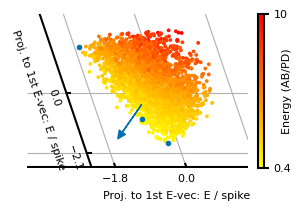

In [51]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig = plt.figure(figsize=(3.1, 2.0))
    viz.curvelinear_test1(
        fig,
        angle_within_90deg,
        projected_num_spikes,
        projected_e_per_spike,
        energy_PM_train,
        parameter_set1_dim1,
        parameter_set1_dim2,
        parameter_set2_dim1,
        parameter_set2_dim2,
        parameter_set3_dim1,
        parameter_set3_dim2,
    )
    plt.savefig(PANEL_F1, facecolor="None", transparent=True)
    plt.show()

### Run simulations

In [52]:
all_energies_per_spike = x["energies_per_spike"]["PM"].to_numpy()
all_energies = x["energies"]["PM"].to_numpy()
all_num_spikes = x["num_spikes"]["PM"].to_numpy()

min_energy_per_spike = np.min(all_energies_per_spike)
max_energy_per_spike = np.max(all_energies_per_spike)

min_energy = np.min(all_energies)
max_energy = np.max(all_energies)

min_num_spikes = np.min(all_num_spikes)
max_num_spikes = np.max(all_num_spikes)

In [53]:
unnorm_set_dim_1 = pd.DataFrame(parameter_set1[:1], columns=theta.columns)
unnorm_set_dim_2 = pd.DataFrame(parameter_set2[:1], columns=theta.columns)
unnorm_set_dim_3 = pd.DataFrame(parameter_set3[:1], columns=theta.columns)

simulation_output_1 = simulate(
    unnorm_set_dim_1.loc[0], seed=0, track_energy=True, track_currents=True
)
simulation_output_2 = simulate(
    unnorm_set_dim_2.loc[0], seed=0, track_energy=True, track_currents=True
)
simulation_output_3 = simulate(
    unnorm_set_dim_3.loc[0], seed=0, track_energy=True, track_currents=True
)

## Plot the traces

In [54]:
time_vec = np.arange(0, 11000, 0.025)

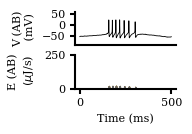

In [55]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_1,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=121000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_G1, facecolor="None", transparent=True)

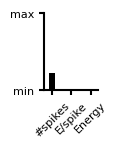

In [56]:
summstats = summary_stats(
    simulation_output_1,
    stats_customization={
        "energies": True,
        "num_spikes": True,
        "energies_per_spike": True,
    },
)
num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.bars_for_energy(
        num_spikes_ABPD,
        min_num_spikes,
        max_num_spikes,
        energyperspike_ABPD_sim,
        min_energy_per_spike,
        max_energy_per_spike,
        energies_ABPD_sim,
        min_energy,
        max_energy,
    )
    plt.savefig(PANEL_G2, facecolor="None", transparent=True)
    plt.show()

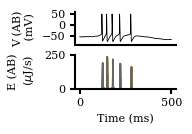

In [57]:
# simulation_output_2 = simulate(
#     unnorm_set_dim_2.loc[0], seed=20, track_energy=True, track_currents=True
# )

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_2,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,  # 0, 20000, 193000, 20000, 302800
        offset=161000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_H1, facecolor="None", transparent=True)

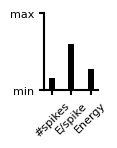

In [58]:
summstats = summary_stats(
    simulation_output_2,
    stats_customization={
        "energies": True,
        "num_spikes": True,
        "energies_per_spike": True,
    },
)
num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.bars_for_energy(
        num_spikes_ABPD,
        min_num_spikes,
        max_num_spikes,
        energyperspike_ABPD_sim,
        min_energy_per_spike,
        max_energy_per_spike,
        energies_ABPD_sim,
        min_energy,
        max_energy,
    )
    plt.savefig(PANEL_H2, facecolor="None", transparent=True)
    plt.show()

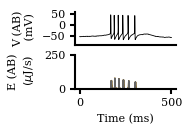

In [59]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_3,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=58000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_I1, facecolor="None", transparent=True)

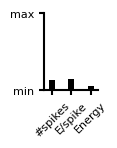

In [60]:
summstats = summary_stats(
    simulation_output_3,
    stats_customization={
        "energies": True,
        "num_spikes": True,
        "energies_per_spike": True,
    },
)
num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.bars_for_energy(
        num_spikes_ABPD,
        min_num_spikes,
        max_num_spikes,
        energyperspike_ABPD_sim,
        min_energy_per_spike,
        max_energy_per_spike,
        energies_ABPD_sim,
        min_energy,
        max_energy,
    )
    plt.savefig(PANEL_I2, facecolor="None", transparent=True)
    plt.show()

## Assemble figure

In [61]:
time_vec = np.arange(0, 11000, 0.025)

In [62]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [67]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "13.0cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", -5.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(5*factor_svg, 7*factor_svg),

    Panel(
          SVG(PANEL_B).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -2.0*factor_svg, 1.8*factor_svg, **kwargs_text),
          Text("inactive", 15.0*factor_svg, 7.0*factor_svg, **kwargs_text8pt),
          Text("active", 11.0*factor_svg, 13.5*factor_svg, **kwargs_text8pt),
    ).move(45*factor_svg, 0.7*factor_svg),
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(89*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
          Text("d", -3*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(3.0*factor_svg, 25.0*factor_svg),

    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(44.0*factor_svg, 26.0*factor_svg),

    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(44*factor_svg, 41.5*factor_svg),

    Panel(
          SVG(PANEL_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", 11.1*factor_svg, 9.9*factor_svg, **kwargs_text8pt_blue),
        Text("h", 26.5*factor_svg, 25.3*factor_svg, **kwargs_text8pt_blue),
        Text("i", 22.0*factor_svg, 20.5*factor_svg, **kwargs_text8pt_blue),
        Text("f", -2.0*factor_svg, -1.1*factor_svg, **kwargs_text),
    ).move(92*factor_svg, 28.0*factor_svg),

    Panel(
          SVG(PANEL_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(92*factor_svg, 50.7*factor_svg),

    Panel(
          SVG(PANEL_H1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 150+40.0*factor_svg),

    Panel(
          SVG(PANEL_H2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(29*factor_svg, 150+39.5*factor_svg),

    Panel(
          SVG(PANEL_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("h", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(48*factor_svg, 150+40*factor_svg),

    Panel(
          SVG(PANEL_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(75*factor_svg, 150+39.5*factor_svg),

    Panel(
          SVG(PANEL_I1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("i", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(94*factor_svg, 150+40*factor_svg),

    Panel(
          SVG(PANEL_I2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(121*factor_svg, 150+39.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/prep016_fig1_raw.svg")
svg('../fig/prep016_fig1_raw.svg')

### Build appendix

In [69]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.7cm",

    Panel(
          SVG(PANEL_supp_EV1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 2.1*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/prep016_fig3_supp2.svg")
svg('../fig/prep016_fig3_supp2.svg')

In [70]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.0cm",

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, -0.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/prep016_fig3_supp1.svg")
svg('../fig/prep016_fig3_supp1.svg')

In [71]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.8cm",

    Panel(
          SVG(PANEL_supp_synapses1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 2.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(28*factor_svg, 0.*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(53*factor_svg, 0.*factor_svg),
)

!mkdir -p fig
f.save("../fig/prep016_fig3_supp3.svg")
svg('../fig/prep016_fig3_supp3.svg')